In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/yurin/pyAtmosphere

import cupy
import numpy as np
from matplotlib import pyplot as plt

from aqc.aqc import AQC
from aqc.grid import RectGrid, RandLogPolarGrid
from aqc.sources import GaussianSource
from aqc.pathes import IdenticalPhaseScreensPath
from aqc.phase_screens import SSPhaseScreen
from aqc.pupils import CirclePupil
from aqc.theory.models import MVKModel, KModel

# from aqc.simulations import SFSimulation, SISimulation, BeamPropagationSimulation, EtaSimulation, PDTSimulation
from aqc.measures import I
from aqc.theory.atmosphere import get_rytov2


/home/yurin/pyAtmosphere


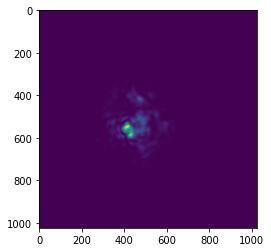

In [2]:
channel = AQC(
  grid=RectGrid(
    resolution=2**10, 
    delta=0.001
  ),
  source=GaussianSource(
      wvl=808e-9,
      w0=0.09,
      F0=np.inf
  ),
  path=IdenticalPhaseScreensPath(
    phase_screen=SSPhaseScreen(
      model=MVKModel(
        Cn2=1e-15,
        l0=6e-3,
        L0=1e3,
      ),
      f_grid=RandLogPolarGrid(
        points=2**10, 
        f_min=1 / 1e3 / 15, 
        f_max=1 / 6e-3 * 2
      )
    ),
    length=10e3,
    count=5
  ),
  pupil=CirclePupil(
    radius=0.02
  ),
)
plt.imshow(I(channel, pupil=False).get())

In [3]:
SR = np.sqrt(get_rytov2(channel.path.phase_screen.model.Cn2, channel.source.k, channel.path.length))
print("Rytov parameter: ", SR)

Rytov parameter:  1.7030766129175547


In [162]:
from aqc.measures import eta, I, mean_x, mean_r2, mean_x2
from aqc.simulation import Simulation, Measures
from aqc.results.beam_wandering import BeamResult
from aqc.results.pdt import PDTResult
from aqc.results.wind import TimeCoherenceResult, TimeBWcorrSimulation
from aqc.results.structure_function import StructureFunctionResult
from aqc.results.si import SIResult

In [163]:
i_measure = Measures(channel, "atmosphere")
beam_result = BeamResult(channel, max_length=2e2)
pdt_result = PDTResult(channel, max_length=1e6)
tc_result = TimeCoherenceResult(channel, time=[0, 0.01, 0.05])
tbwcorr_result = TimeBWcorrSimulation(channel, time=[0, 0.01, 0.06])
sf_result = StructureFunctionResult(channel, max_length=1e2)
si_result = SIResult(channel, max_length=1e4)

In [170]:
sf_result.set_max_length(341)

sigma_BW_x = 4.0e-02 +- 2.2e-03
sigma_LT_x = 8.6e-02 +- 1.2e-03
W_ST = 1.5e-01 +- 1.3e-03


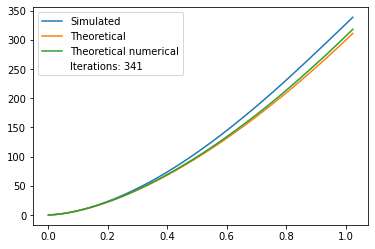

In [171]:
a = Simulation(results_list=[beam_result, sf_result])
a.run(plot_step=30)

0.05071433604381535 0.07172090183991037


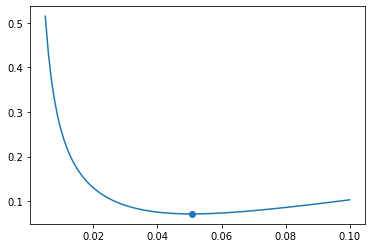

In [172]:
from aqc.theory.sources import GaussianBeam
x = np.linspace(0.005, 0.1, 100)
plt.plot(x, [GaussianBeam(channel.source.wvl, i, channel.source.F0).get_w(channel.path.length) for i in x])
w0min = np.sqrt(channel.path.length * channel.source.wvl / np.pi)
plt.scatter(w0min, GaussianBeam(channel.source.wvl, w0min, channel.source.F0).get_w(channel.path.length))
print(w0min, GaussianBeam(channel.source.wvl, w0min, channel.source.F0).get_w(channel.path.length))